/var/folders/9y/fbqptfm91cv58jfzq06lhlk40000gn/T/ipykernel_18148/702969351.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read("../Documents/rec1.wav")


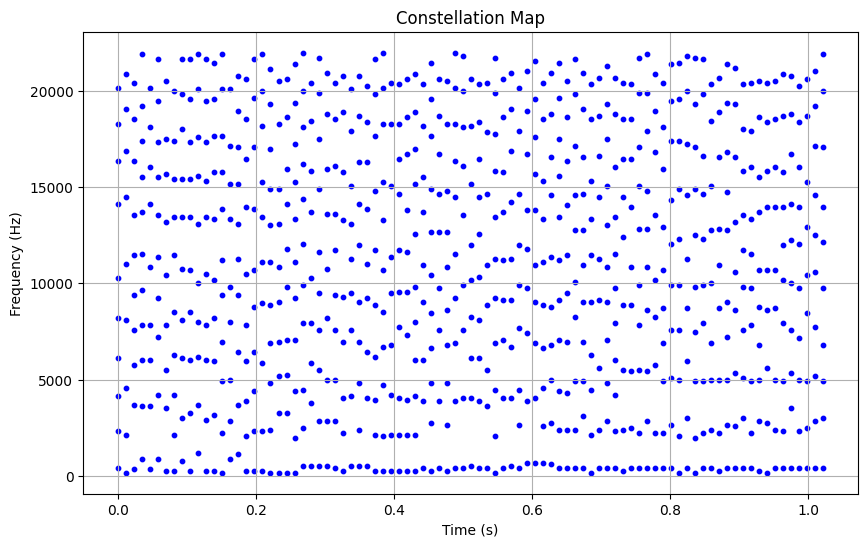

ConnectionError: HTTPConnectionPool(host='51.120.246.62', port=8080): Max retries exceeded with url: /song/1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x176aba510>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [31]:
import numpy as np
from scipy import signal
from scipy.io.wavfile import read
import requests


# Création de la constellation des pics significatifs
# audio_data correspond au data du fichier .wav
# fs correspond à la fréquence d'échantillonage

def create_peak_constellation(audio_data, Fs):
    num_peaks = 15

    # On applique une STFT sur l'audio étudié

    frequencies, times, stft = signal.stft(
        x = audio_data, fs = Fs, nperseg= 512, nfft = 512, return_onesided=True, noverlap= 0,
    )

    constellation_map = []

    for time_index, window in enumerate(stft.T):
        # On convertit le spectre en valeur réel
        spectrum = abs(window)
        
        # On identifie les pics les plus importants 
        peaks, props = signal.find_peaks(spectrum, prominence=0, distance=21)

        n_peaks = min(num_peaks, len(peaks))

        largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
        for peak in peaks[largest_peaks]:
            frequency = frequencies[peak]
            time_in_seconds = times[time_index]
            constellation_map.append([time_in_seconds, frequency])
    
    return constellation_map

Fs, data = read("../Documents/rec1.wav")
constellation = create_peak_constellation(data,Fs)


import matplotlib.pyplot as plt


times = [point[0] for point in constellation]
frequencies = [point[1] for point in constellation]

plt.figure(figsize=(10, 6))
plt.scatter(times, frequencies, marker='o', color='b', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Constellation Map')
plt.grid(True)
plt.show()

def create_data(constellation_map):
    upper_frequency = 23000
    frequency_bits = 10
    data = []

    # On parcourt la constellation pour créer les hashs
    for idx, (time, freq) in enumerate(constellation_map[:-1]):

        other_freq = constellation_map[idx + 1][1]

        time_diff = constellation_map[idx + 1][0] - time
        freq_diff = abs(other_freq - freq)

        if time_diff <= 0 and freq_diff <= 3000 :
            continue

        freq_binned = freq / upper_frequency * (2 ** frequency_bits)
        other_freq_binned = other_freq / upper_frequency * (2 ** frequency_bits)

        invariant = freq_binned/other_freq_binned

        data.append({
            "invariantComponent": invariant,
            "variantComponent": time_diff,
            "localisation": time,
            "songID": 1
        })

    return data


def send_data_in_batches(data, url,batch_size=50):
    all_responses = []
    headers = {
    'Content-Type': 'application/json'
    }

    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        response = requests.post(url, json=batch, headers=headers)

        if response.status_code == 200:
            print(f'Batch {i//batch_size + 1} envoyé avec succès')
            print(f'Réponse du serveur : {response.text}')

            all_responses.append(response.json())
        else:
            print(f'Erreur lors de l\'envoi du batch {i//batch_size + 1}, statut: {response.status_code}')
            print(f'Réponse du serveur : {response.text}')
    
    return all_responses

def create_histograms(all_responses):
    # Pour chaque reponse (indice array)
        # Pour chaque clé de map
            # Pour chaque pair de finger print en DB et Enregistré, faire la différence de "localisation"
                #  Ajouter 1 à la valeur de la "localisation" de l'histogramme associé à la clé de la map
    # Retourner la liste qui contient le nombre d'occurence de la différence de localisation par histogramme

    # Initialisation d'un dictionnaire pour stocker les histogrammes des différences de localisation
    histograms = {}

    for response in all_responses:
        # Pour chaque clé dans la réponse (songID)
        for song_id, matches in response.items():
            if song_id not in histograms:
                histograms[song_id] = {}

            # Pour chaque paire de fingerprints dans les correspondances
            for match in matches:
                song_fp = match['songFingerprint']
                db_fp = match['databaseFingerprint']

                # Calcul de la différence de localisation
                local_diff = song_fp['localisation'] - db_fp['localisation']

                # Mise à jour de l'histogramme pour ce song_id
                if local_diff not in histograms[song_id]:
                    histograms[song_id][local_diff] = 0

                histograms[song_id][local_diff] += 1

    return histograms

def find_best_match(histograms):
    # Pour chaque histogramme
        # Pour chaque clé de l'histogramme
            # Si la valeur de la clé est supérieure à 10
                # Ajouter la clé à la liste des candidats
    # Retourner le candidat avec la valeur la plus élevée

    best_match = None
    best_score = 0
    count_offset = 10

    for song_id, histogram in histograms.items():
        for local_diff, count in histogram.items():
            if count > count_offset:
                if count > best_score:
                    best_score = count
                    best_match = song_id

    return best_match

def get_song_info(song_id):
    headers = {
    'Content-Type': 'application/json'
    }
    url = 'http://51.120.246.62:8080/song/'
    response = requests.get(url=url + str(song_id),headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        return None


    

Reponses = []
Reponse1 = {"1":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse2 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse3 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse4 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse5 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse6 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse7 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse8 = {"8":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse9 = {"9":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse10 = {"10":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}
Reponse11= {"11":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}

Reponses.append(Reponse1)
Reponses.append(Reponse2)
Reponses.append(Reponse3)
Reponses.append(Reponse4)
Reponses.append(Reponse5)
Reponses.append(Reponse6)
Reponses.append(Reponse7)
Reponses.append(Reponse8)
Reponses.append(Reponse9)
Reponses.append(Reponse10)
Reponses.append(Reponse11)


#histogram = create_histograms(Reponses)
#best_match = find_best_match(histogram)
#print(best_match)

test = get_song_info(1)
print(test)

#print(histogram['1']['0.0'])

#url = 'http://51.120.246.62:8080/fingerprint/'  
#url = 'http://51.120.246.62:8080/fingerprint/compare/' 




# test = {"1":[{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1}},{"songFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324263037,"localisation":0.0,"songID":1},"databaseFingerprint":{"invariantComponent":0.02066115702479339,"variantComponent":0.011609977324262943,"localisation":0.7662585034013606,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1},"databaseFingerprint":{"invariantComponent":0.015037593984962407,"variantComponent":0.01160997732426304,"localisation":0.011609977324263037,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1},"databaseFingerprint":{"invariantComponent":0.9330708661417323,"variantComponent":0.011609977324263037,"localisation":0.023219954648526078,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1},"databaseFingerprint":{"invariantComponent":0.042735042735042736,"variantComponent":0.01160997732426304,"localisation":0.034829931972789115,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1},"databaseFingerprint":{"invariantComponent":0.01593625498007968,"variantComponent":0.01160997732426304,"localisation":0.046439909297052155,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1},"databaseFingerprint":{"invariantComponent":0.04201680672268908,"variantComponent":0.011609977324263047,"localisation":0.058049886621315196,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1},"databaseFingerprint":{"invariantComponent":0.014851485148514853,"variantComponent":0.011609977324263027,"localisation":0.06965986394557824,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1},"databaseFingerprint":{"invariantComponent":0.9243027888446215,"variantComponent":0.01160997732426304,"localisation":0.08126984126984127,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1},"databaseFingerprint":{"invariantComponent":0.03585657370517928,"variantComponent":0.01160997732426304,"localisation":0.09287981859410431,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.13931972789115646,"songID":1}},{"songFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.01160997732426304,"localisation":0.10448979591836735,"songID":1},"databaseFingerprint":{"invariantComponent":0.011811023622047244,"variantComponent":0.011609977324263027,"localisation":0.19736961451247165,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1},"databaseFingerprint":{"invariantComponent":0.05577689243027888,"variantComponent":0.011609977324263013,"localisation":0.11609977324263039,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}},{"songFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1},"databaseFingerprint":{"invariantComponent":0.012048192771084336,"variantComponent":0.011609977324263054,"localisation":0.1277097505668934,"songID":1}}]}



#print(test["1"][2]["databaseFingerprint"]["invariantComponent"])


